## noise_mcmc.ipynbで書き出したトレースファイルを読み出して確認

In [184]:
from wave_audio import write
import pymc3 as pm
import arviz as az
import pickle
import wave
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-darkgrid')
plt.rcParams['font.family'] = 'Noto Sans CJK JP'
plt.rcParams['font.size'] = 17

In [185]:
with open('data_folder/audio_trace.pkl', 'rb') as f:
    d = pickle.load(f)

値と収束チェック

In [183]:
pm.summary(d)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w[0],0.377,0.055,0.272,0.477,0.000,0.000,17140.0,23766.0,1.0
w[1],0.478,0.061,0.362,0.589,0.000,0.000,17860.0,18009.0,1.0
w[2],0.146,0.031,0.091,0.205,0.000,0.000,24973.0,20852.0,1.0
mu[0],-0.935,0.060,-1.046,-0.823,0.000,0.000,18030.0,25689.0,1.0
mu[1],0.295,0.109,0.089,0.494,0.001,0.001,19598.0,20981.0,1.0
mu[2],1.464,0.066,1.339,1.587,0.000,0.000,26268.0,24043.0,1.0
tau[0],4.163,0.446,3.376,5.024,0.003,0.002,20004.0,28889.0,1.0
tau[1],2.472,0.559,1.651,3.511,0.004,0.003,20248.0,19667.0,1.0
tau[2],6.377,1.088,4.407,8.434,0.007,0.005,27120.0,27006.0,1.0


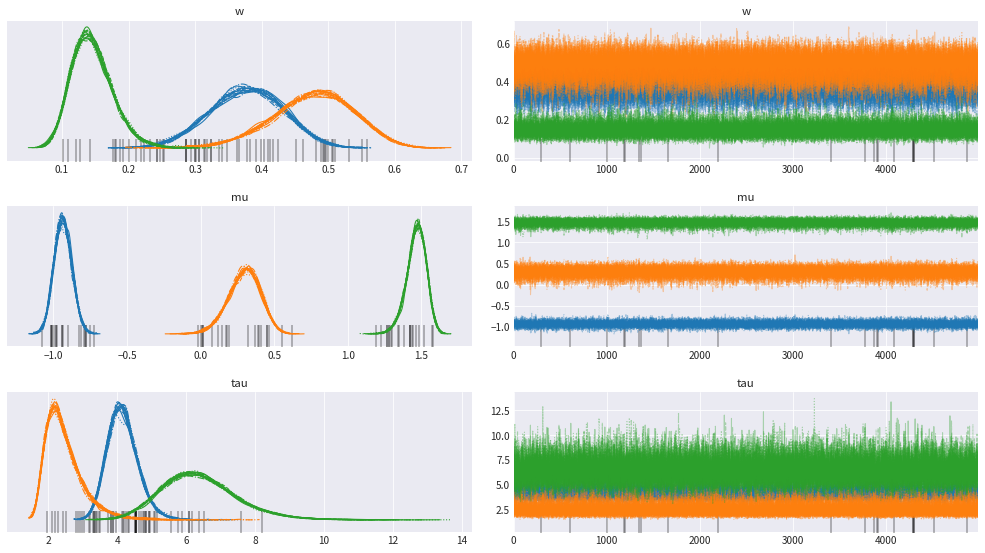

In [141]:
az.plot_trace(d, var_names=['w','mu','tau'], figsize=(14, 8))
plt.tight_layout()
plt.savefig('data_folder/探索結果.png', bbox_inches='tight', pad_inches=0.3)
plt.show()

事後予測サンプルを取得

In [5]:
x = d.posterior_predictive.to_array()
x = x.to_numpy()
x_all = x.reshape(-1)

In [187]:
# ランダムに288000個のデータを取り出す
rng = np.random.default_rng()
x_pred_obs = rng.choice(x_all, 288000, replace=True)

In [55]:
x_pred_obs

array([-0.41854531, -0.79811601,  1.27140797, ...,  0.51097795,
        0.38560735,  1.39128678])

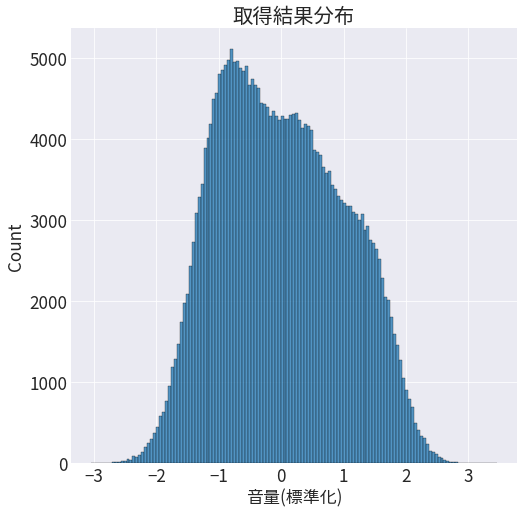

In [170]:
plt.figure(figsize=(8, 8))
sns.histplot(x_pred_obs)
plt.xlabel('音量(標準化)')
plt.title('取得結果分布')
plt.savefig('data_folder/取得結果分布.png', bbox_inches='tight', pad_inches=0.3)
plt.show()

標準化データを読み込んで値をもとの大きさに戻す

In [57]:
scaler = pickle.load(open('data_folder/obs_standard_data.pkl', 'rb'))
x_pred_restore = scaler.inverse_transform(x_pred_obs.reshape(-1, 1)).reshape(-1).astype(np.int16)

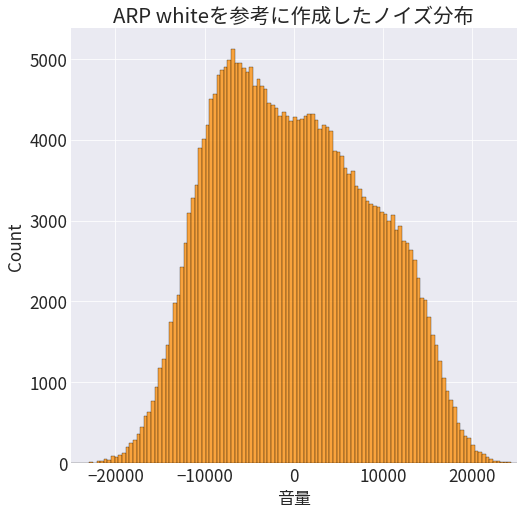

In [175]:
plt.figure(figsize=(8, 8))
sns.histplot(x_pred_restore, color='darkorange')
plt.title('ARP whiteを参考に作成したノイズ分布')
plt.xlabel('音量')
plt.xlim(-25000, 25000)
plt.savefig('data_folder/posterior_predictive_noise.png', bbox_inches='tight', pad_inches=0.3)
plt.show()

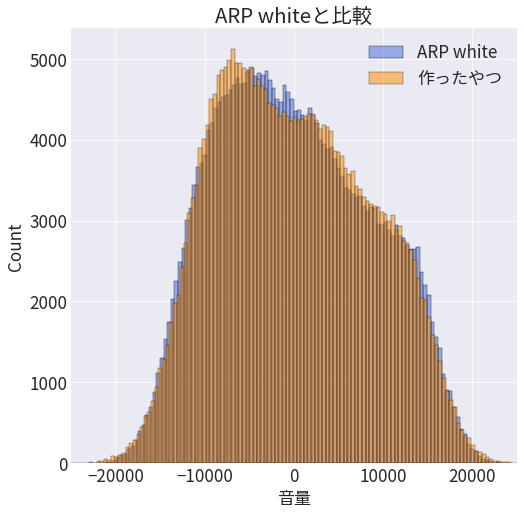

In [ ]:
# plt.figure(figsize=(8, 8))
# sns.histplot(audio_data, color='royalblue', alpha=0.5, label='ARP white')
# sns.histplot(x_pred_restore, color='darkorange', alpha=0.5, label='作ったやつ')
# plt.title('ARP whiteと比較')
# plt.xlabel('音量')
# plt.xlim(-25000, 25000)
# plt.legend(loc='upper right')
# plt.savefig('data_folder/比較.png', bbox_inches='tight', pad_inches=0.3)
# plt.show()

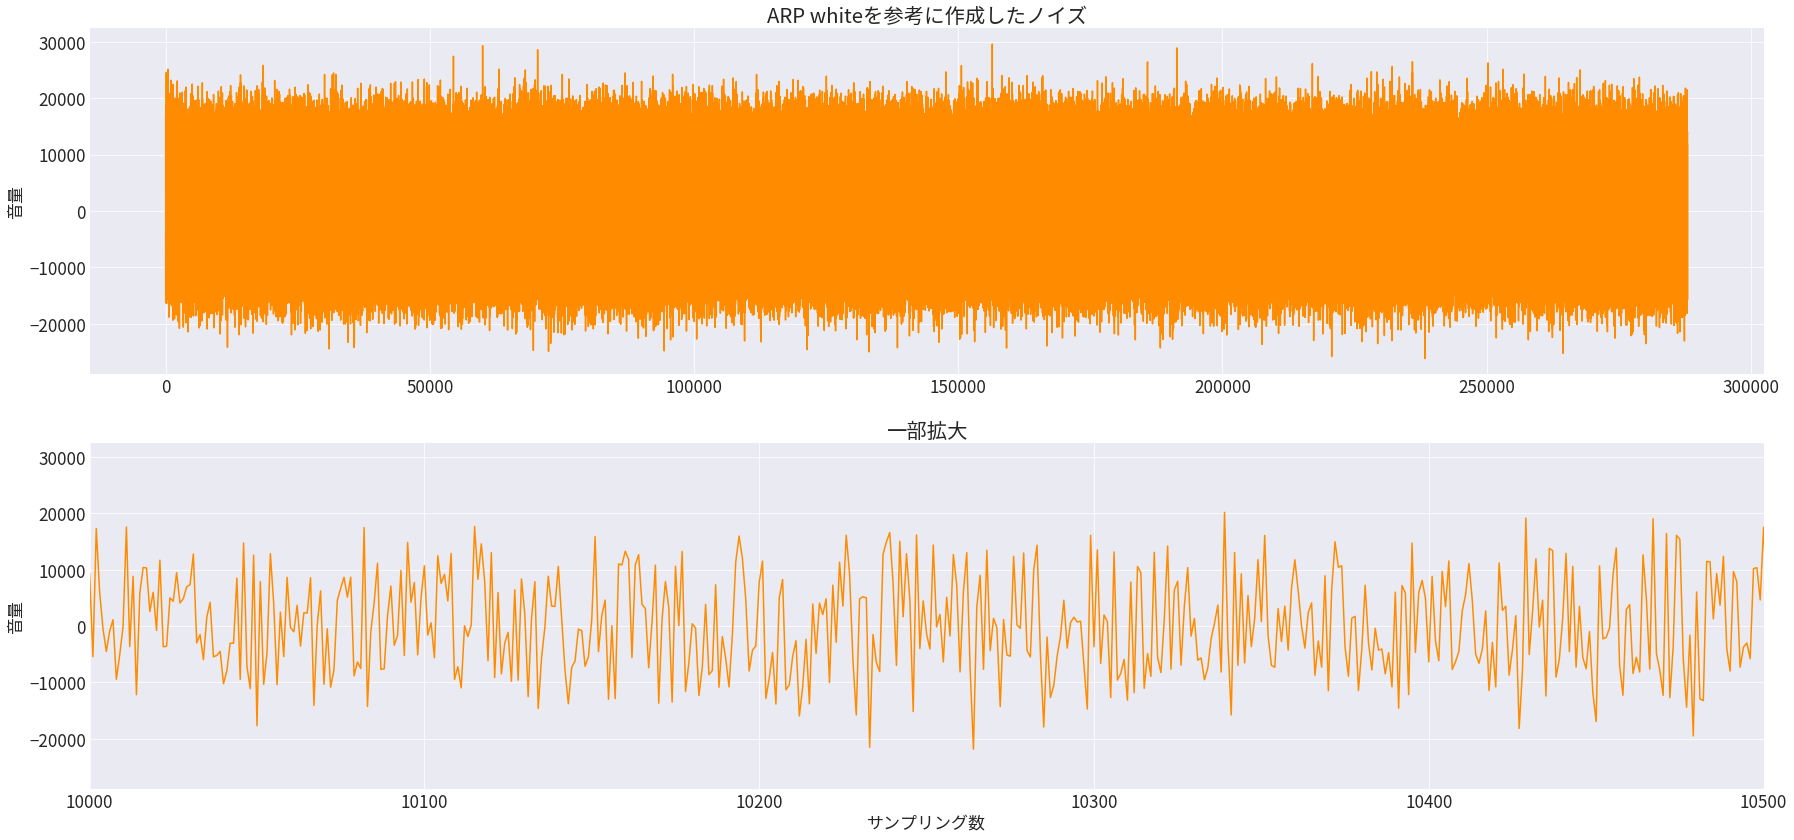

In [177]:
plt.figure(figsize=(30, 14))
plt.subplot(211)
plt.plot(x_pred_restore, color='darkorange')
plt.title('ARP whiteを参考に作成したノイズ')
plt.ylabel('音量')
plt.subplot(212)
plt.plot(x_pred_restore, color='darkorange')
plt.title('一部拡大')
plt.xlabel('サンプリング数')
plt.xlim(10000, 10500)
plt.ylabel('音量')
plt.savefig('data_folder/white_noise_result.png', bbox_inches='tight', pad_inches=.3)
plt.show()

In [115]:
write(1, 2, 48000, x_pred_restore, 'data_folder/生成ノイズ.wav')